In [ ]:
# Install dependencies (if running in a notebook)
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 w

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

# Import Hugging Face modules
from transformers import (
    AutoTokenizer,
    GPT2LMHeadModel,
    GPT2Config
)
# We also import the original GPT-2 block definition to subclass it.
from transformers.models.gpt2.modeling_gpt2 import GPT2Block

In [ ]:
# ------------------------------
# Hyperparameters and settings
# ------------------------------
MODEL_NAME = "gpt2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2
LR = 6e-5
MAX_SEQ_LENGTH = 32      # maximum sequence length for training examples
NUM_EPOCHS = 100           # For demonstration we use few epochs (use more in practice)
SHOW_SAMPLE_OUTPUTS = True   # Whether to show sample text generations for comparison
GRAD_CLIP = 1.0
# L1_COEFF = 1e-1          # Coefficient for L1 penalty on attention mask weights
L1_COEFF = 0

print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
# ------------------------------
# Load the baseline (reference) GPT-2 model and tokenizer.
# This model is used only for generating target logits.
# ------------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# Ensure the tokenizer has a pad token (set to the EOS token if missing)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load the reference model (unmodified GPT-2)
reference_model = GPT2LMHeadModel.from_pretrained(MODEL_NAME)
reference_model.to(DEVICE)
reference_model.eval()   # Freeze the reference model (do not train it)
print(f"Reference model '{MODEL_NAME}' loaded successfully!")

Reference model 'gpt2' loaded successfully!


In [ ]:
# ------------------------------
# Custom Attention Module: Learnable Weighted Combination of Candidate Masks
# ------------------------------
class CustomLearnableAttention(nn.Module):
    """
    This custom attention module uses the standard Q, K, V projections
    but instead of using a fixed attention mask (or a fixed sliding window),
    it computes several candidate binary masks and then forms a weighted combination
    of them. The weights are learnable parameters (passed through a sigmoid) and
    an L1 penalty will be applied to encourage sparsity (i.e. use as few tokens as possible).

    Candidate masks defined:
      - Candidate 0: Only attend to the last 5 tokens.
      - Candidate 1: Only attend to the last 10 tokens.
      - Candidate 2: Only atttend to the first 5 tokens.
    """
    def __init__(self, d_model, num_heads, num_candidates=3):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        self.num_candidates = num_candidates

        # Linear projection layers for queries, keys, and values.
        self.query_proj = nn.Linear(d_model, d_model)
        self.key_proj = nn.Linear(d_model, d_model)
        self.value_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        # Learnable coefficients for each candidate mask.
        # We initialize so that the first 5 token mask (candidate 2) is favored initially.
        init_alpha = torch.randn(3)
        self.alpha = nn.Parameter(init_alpha)  # shape: (num_candidates,)

    def forward(self, hidden_states, attention_mask=None, **kwargs):
        batch_size, seq_length, _ = hidden_states.size()
        device = hidden_states.device

        # Project hidden states to Q, K, V.
        q = self.query_proj(hidden_states)  # shape: (B, L, d_model)
        k = self.key_proj(hidden_states)
        v = self.value_proj(hidden_states)

        # Reshape into multiple heads: (B, num_heads, L, head_dim)
        q = q.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute raw attention scores.
        scaling_factor = self.head_dim ** 0.5
        scores = torch.matmul(q, k.transpose(-2, -1)) / scaling_factor  # shape: (B, num_heads, L, L)

        # (Optional) Apply any provided attention mask (e.g. for padding).
        if attention_mask is not None:
            # print("Applying attention mask with shape:", attention_mask.shape)
            # If the mask is of shape (B, L), expand it to (B, 1, 1, L)
            if attention_mask.dim() == 2:
                extended_attention_mask = attention_mask[:, None, None, :]
            # If it already has 4 dimensions (B, 1, L, L) or similar, use it as is.
            elif attention_mask.dim() == 4:
                extended_attention_mask = attention_mask
            else:
                raise ValueError("Unexpected attention_mask dimensions: " + str(attention_mask.shape))
            # scores = scores.masked_fill(extended_attention_mask == 0, float('-inf'))
            scores = scores.masked_fill(extended_attention_mask == 0, -1e9)


        # -----------------------------------------------
        # Compute the weighted learnable attention mask.
        # -----------------------------------------------
        # 1) Compute candidate masks based on the current sequence length.
        candidate_masks = self._get_candidate_masks(seq_length, device=device)  # shape: (num_candidates, L, L)

        # 2) Add two new dimensions so that we can combine with the batch and head dims.
        candidate_masks = candidate_masks.unsqueeze(0).unsqueeze(0)  # shape: (1, 1, num_candidates, L, L)

        # 3) Compute learnable weights from self.alpha.
        #    (We use a sigmoid to constrain each weight to [0,1].)
        w = torch.sigmoid(self.alpha)  # shape: (num_candidates,)

        # Reshape weights for broadcasting: (1, 1, num_candidates, 1, 1)
        w = w.view(1, 1, self.num_candidates, 1, 1)

        # 4) Form the weighted sum over candidate masks.
        final_mask = torch.sum(w * candidate_masks, dim=2)  # shape: (1, 1, L, L)

        # Expand final_mask over batch and heads.
        final_mask = final_mask.expand(batch_size, self.num_heads, seq_length, seq_length)

        # -------------------------------------------------
        # Now compute the final attention probabilities.
        # First, get the standard softmax attention probabilities.
        attn_probs = F.softmax(scores, dim=-1)  # shape: (B, num_heads, L, L)

        # Multiply elementwise by our learnable mask.
        attn_probs = attn_probs * final_mask
        # Renormalize over the key dimension.
        attn_probs = attn_probs / (attn_probs.sum(dim=-1, keepdim=True) + 1e-8)

        # Compute the context as the weighted sum of the values.
        context = torch.matmul(attn_probs, v)  # shape: (B, num_heads, L, head_dim)

        # Recombine heads.
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        output = self.out_proj(context)
        return output

    def _get_candidate_masks(self, seq_length, device):
        """
        For each candidate, we build a binary (0/1) mask of shape (seq_length, seq_length)
        where each row i indicates which key tokens (columns) the query token i is allowed to attend to.
        """
        masks = []
        # Candidate 0: last 5 tokens
        mask_last_5 = torch.zeros(seq_length, seq_length, device=device)
        for i in range(seq_length):
            start = max(0, i - 4)  # allow up to 5 tokens (including current)
            mask_last_5[i, start:i+1] = 1.0
        masks.append(mask_last_5)

        # Candidate 1: last 10 tokens
        mask_last_10 = torch.zeros(seq_length, seq_length, device=device)
        for i in range(seq_length):
            start = max(0, i - 9)
            mask_last_10[i, start:i+1] = 1.0
        masks.append(mask_last_10)

        # Candidate 2: first 5 tokens
        mask_first_5 = torch.zeros(seq_length, seq_length, device=device)
        for i in range(seq_length):
            end = min(4, i)
            mask_first_5[i, 0:end+1] = 1.0
        masks.append(mask_first_5)

        masks = torch.stack(masks, dim=0)  # shape: (num_candidates, seq_length, seq_length)
        return masks

In [ ]:
# ------------------------------
# Custom GPT-2 Block with our CustomLearnableAttention
# ------------------------------
class CustomGPT2Block(GPT2Block):
    """
    Subclass the original GPT2Block to replace the attention layer with our custom one.
    We also copy the original Q, K, V, and output projection weights so that the custom
    attention begins with a similar behavior to the baseline.
    """
    def __init__(self, config):
        super().__init__(config)
        # Replace the default attention with our custom attention.
        self.attn = self._create_custom_attention(config)

    def _create_custom_attention(self, config):
        # Instantiate our custom attention module.
        custom_attn = CustomLearnableAttention(config.n_embd, config.n_head)
        original_attn = self.attn  # the original GPT2Attention layer

        # The original attention concatenates Q, K, V in a single linear layer.
        # We split the weights from the original model and copy them into our projections.
        q_w, k_w, v_w = original_attn.c_attn.weight.chunk(3, dim=1)
        q_b, k_b, v_b = original_attn.c_attn.bias.chunk(3, dim=0)
        custom_attn.query_proj.weight.data.copy_(q_w)
        custom_attn.query_proj.bias.data.copy_(q_b)
        custom_attn.key_proj.weight.data.copy_(k_w)
        custom_attn.key_proj.bias.data.copy_(k_b)
        custom_attn.value_proj.weight.data.copy_(v_w)
        custom_attn.value_proj.bias.data.copy_(v_b)
        # Copy the output projection weights.
        custom_attn.out_proj.load_state_dict(original_attn.c_proj.state_dict())
        return custom_attn

    def forward(self, hidden_states, layer_past=None, attention_mask=None,
                head_mask=None, use_cache=False, output_attentions=False, **kwargs):
        # Standard GPT-2 block forward pass with two residual connections.
        attn_input = self.ln_1(hidden_states)
        attn_output = self.attn(attn_input, attention_mask=attention_mask)
        hidden_states = hidden_states + attn_output

        mlp_input = self.ln_2(hidden_states)
        mlp_output = self.mlp(mlp_input)
        hidden_states = hidden_states + mlp_output

        # We do not use caching in our custom model.
        return (hidden_states, None, None)

In [ ]:
# ------------------------------
# Custom GPT-2 LM Model that Uses the Custom Blocks
# ------------------------------
class CustomGPT2LM(GPT2LMHeadModel):
    """
    This custom language model replaces each Transformer block with our custom block
    (which uses the learnable attention mask). In addition, we share the word and
    positional embeddings, as well as the LM head, with the reference model.
    """
    def __init__(self, config, reference_model):
        super().__init__(config)
        # Disable caching for generation.
        self.config.use_cache = False

        # Share embeddings and the language model head from the reference model.
        self.transformer.wte = reference_model.transformer.wte
        self.transformer.wpe = reference_model.transformer.wpe
        self.lm_head = reference_model.lm_head

        # Replace all Transformer blocks with our custom blocks.
        self.transformer.h = nn.ModuleList([CustomGPT2Block(config) for _ in range(config.n_layer)])
        # Load weights from the reference model (allowing missing keys since our modules are modified).
        self.load_state_dict(reference_model.state_dict(), strict=False)

In [ ]:
# ------------------------------
# Prepare the Dataset and Dataloader using wikitext-2
# ------------------------------
# We create a simple Dataset that tokenizes the raw texts from wikitext.
class WikiTextDataset(Dataset):
    def __init__(self, tokenizer, texts, max_length=32):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.texts = texts
        self.encodings = []

        for txt in texts:
            # Tokenize each text and pad/truncate to max_length.
            enc = tokenizer.encode_plus(
                txt,
                max_length=self.max_length,
                truncation=True,
                padding="max_length",
                return_tensors="pt"
            )
            self.encodings.append(enc)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.encodings[idx]
        input_ids = enc["input_ids"].squeeze(0)         # shape: (max_length,)
        attention_mask = enc["attention_mask"].squeeze(0)   # shape: (max_length,)
        return input_ids, attention_mask

In [ ]:
# Load the wikitext-2 dataset using the Hugging Face datasets library.
from datasets import load_dataset
wikitext_data = load_dataset("wikitext", "wikitext-2-raw-v1")
# For demonstration, we take a small subset of the training split.
train_texts = [txt for txt in wikitext_data["train"]["text"] if len(txt) > 50][:1000]

# Create our dataset and dataloader.
dataset = WikiTextDataset(tokenizer, train_texts, max_length=MAX_SEQ_LENGTH)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Dataset and dataloader ready for training!")

Dataset and dataloader ready for training!


In [ ]:
# ------------------------------
# KL-Divergence Loss Function
# ------------------------------
def kl_divergence_loss(logits_custom, logits_ref, mask):
    """
    Compute a token-wise KL-divergence between the output distributions of the custom model
    and the reference model. The loss is averaged over the active (non-padded) tokens.

    logits_custom: (B, L, V)
    logits_ref:    (B, L, V)
    mask:          (B, L) with 1 for active tokens and 0 for padding.
    """
    log_probs_custom = F.log_softmax(logits_custom, dim=-1)
    # Detach the reference probabilities to avoid backprop into the reference model.
    probs_ref = F.softmax(logits_ref.detach(), dim=-1)
    # Compute the per-token KL divergence.
    kl = (probs_ref * (probs_ref.log() - log_probs_custom)).sum(-1)  # shape: (B, L)
    # Average the loss over the active tokens.
    active_tokens = mask.sum()
    return (kl * mask).sum() / active_tokens

In [ ]:
# ------------------------------
# Initialize the Custom Model
# ------------------------------
print("Initializing custom model with learnable attention masks...")
# We re-load the reference model so that the custom model can copy its embeddings and head.
reference_model = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)
custom_config = GPT2Config.from_pretrained(MODEL_NAME)
custom_model = CustomGPT2LM(custom_config, reference_model).to(DEVICE)

# Freeze parameters that are not part of the custom attention (or other parts we want fixed).
for name, param in custom_model.named_parameters():
    # Here we unfreeze only the parameters that include "attn" in their name.
    if "attn" in name:
        param.requires_grad_(True)
    else:
        param.requires_grad_(False)

# Set the custom model to train mode.
custom_model.train()

# Create the optimizer to update only parameters that require gradients.
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, custom_model.parameters()), lr=LR)

Initializing custom model with learnable attention masks...


In [ ]:
def get_alphas(model):
    # Ensure the model is in evaluation mode (optional but recommended when inspecting values)
    model.eval()

    # Choose a sequence length (should match the one used during training, e.g. MAX_SEQ_LENGTH)
    seq_length = MAX_SEQ_LENGTH

    all_alphas = []

    # Iterate over all submodules of the custom model
    for module in model.modules():
        if isinstance(module, CustomLearnableAttention):
            # Print the raw learned alpha coefficients.
            # print("Raw learned alpha coefficients:")
            alphas = module.alpha.detach().cpu().numpy()
            all_alphas.append(alphas)

            # # Print the sigmoid of the alpha coefficients, which are used as weights.
            # alpha_sigmoid = torch.sigmoid(module.alpha)
            # print("Sigmoid(alpha) values (interpreted as weights):")
            # print(alpha_sigmoid.detach().cpu().numpy())

            # # Reproduce the final attention mask computation for a given sequence length.
            # # Step 1: Compute candidate masks.
            # candidate_masks = module._get_candidate_masks(seq_length, device=module.alpha.device)
            # # candidate_masks shape: (num_candidates, seq_length, seq_length)

            # # Step 2: Unsqueeze to add batch and head dimensions.
            # candidate_masks = candidate_masks.unsqueeze(0).unsqueeze(0)
            # # New shape: (1, 1, num_candidates, seq_length, seq_length)

            # # Step 3: Reshape the sigmoid weights for broadcasting.
            # weights = alpha_sigmoid.view(1, 1, module.num_candidates, 1, 1)
            # # Shape becomes: (1, 1, num_candidates, 1, 1)

            # # Step 4: Compute the weighted sum to form the final attention mask.
            # final_mask = torch.sum(weights * candidate_masks, dim=2)
            # # Final mask shape: (1, 1, seq_length, seq_length)

            # print(f"Final combined attention mask (for sequence length = {seq_length}):")
            # print(final_mask.detach().cpu().numpy())

    model.train()
    return np.array(all_alphas)

In [ ]:
# ------------------------------
# Training Loop
# ------------------------------
alphas = get_alphas(custom_model)
print(alphas)
all_alphas = [alphas]
print("Starting training loop...")
for epoch in range(NUM_EPOCHS):
    total_loss = 0.0
    for step, (input_ids, attention_mask) in enumerate(dataloader):
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)

        # 1) Get logits from the reference model (no gradient tracking).
        with torch.no_grad():
            outputs_ref = reference_model(input_ids=input_ids, attention_mask=attention_mask)
            logits_ref = outputs_ref.logits  # shape: (B, L, vocab_size)

        # 2) Get logits from the custom model.
        outputs_custom = custom_model(input_ids=input_ids, attention_mask=attention_mask)
        logits_custom = outputs_custom.logits  # shape: (B, L, vocab_size)

        # 3) Compute KL divergence loss.
        loss_kl = kl_divergence_loss(logits_custom, logits_ref, attention_mask)

        # 4) Compute L1 penalty over all learned attention mask coefficients.
        l1_penalty = 0.0
        for module in custom_model.modules():
            if isinstance(module, CustomLearnableAttention):
                # We apply L1 on the sigmoid of the learned alpha to encourage sparsity.
                l1_penalty += torch.sum(torch.abs(torch.sigmoid(module.alpha)))
        loss = loss_kl + L1_COEFF * l1_penalty

        # 5) Backpropagation and parameter update.
        optimizer.zero_grad()
        loss.backward()
        # Optionally clip gradients.
        torch.nn.utils.clip_grad_norm_(custom_model.parameters(), GRAD_CLIP)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Avg KL-div Loss + L1 Penalty: {avg_loss:.4f}")
    alphas = get_alphas(custom_model)
    print(alphas)
    all_alphas.append(alphas)

[[ 0.6440887  -1.5292557  -0.18683578]
 [-0.43569514  1.5326922  -0.9506381 ]
 [-0.03626842  1.115484    0.10961746]
 [-0.84417635  0.0210231  -0.93527037]
 [ 0.52910817  0.27072695  0.6469236 ]
 [-1.7167864  -1.390804    1.1047593 ]
 [-0.29545012  1.3189579   1.691116  ]
 [ 0.98693824  0.24818072 -0.9989008 ]
 [-0.37490463  0.3941607   0.8807527 ]
 [ 1.5343602  -0.8035802   0.789764  ]
 [ 0.1404899  -1.2779913  -1.3236043 ]
 [-0.9224027   0.03445695  0.14207023]]
Starting training loop...
Epoch [1/100], Avg KL-div Loss + L1 Penalty: 2.1470
[[ 0.64832115 -1.5325823  -0.18962705]
 [-0.41010088  1.5366408  -0.96830183]
 [-0.0102704   1.1272205   0.08971789]
 [-0.8136358   0.02700754 -0.9558411 ]
 [ 0.55617774  0.27648023  0.6267983 ]
 [-1.7004888  -1.3809029   1.0925345 ]
 [-0.27292484  1.3294988   1.6745439 ]
 [ 1.011524    0.23883632 -1.0159467 ]
 [-0.35913053  0.40337634  0.868346  ]
 [ 1.5505344  -0.7967377   0.7753521 ]
 [ 0.15938315 -1.2774594  -1.3393079 ]
 [-0.9046452   0.0471760

In [ ]:
# ------------------------------
# Text Generation Comparison
# ------------------------------
def generate_text(model, prompt, temperature=0.7, top_k=50, max_length=50):
    """
    Generate text using the provided model and prompt.
    Note: We disable caching (use_cache=False) for our custom model.
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    outputs = model.generate(
        inputs.input_ids,
        max_length=max_length,
        do_sample=True,
        temperature=temperature,
        top_k=top_k,
        pad_token_id=tokenizer.eos_token_id,
        repetition_penalty=1.2,
        no_repeat_ngram_size=2,
        use_cache=False  # Disable caching for compatibility with custom attention.
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

if SHOW_SAMPLE_OUTPUTS:
    sample_prompts = [
        "Hello, my name is",
        "The meaning of life is",
        "In a shocking turn of events,",
        "The future of artificial intelligence"
    ]

    for prompt in sample_prompts:
        ref_text = generate_text(reference_model, prompt, temperature=0.9)
        custom_text = generate_text(custom_model, prompt, temperature=0.8)
        print(f"\nPrompt: {prompt}")
        print(f"Reference: {ref_text}")
        print(f"Custom:    {custom_text}")
        print("-" * 80)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Prompt: Hello, my name is
Reference: Hello, my name is Aaron. It took just weeks of work to get this script working and I was so excited right when it started getting released! My secret Santa kept asking me questions about the project if anyone had any feedback from you or anything along
Custom:    Hello, my name is in German; "Wulf," which means a new kind of word . One such as the symbol that emerges from this article.
 The Story We need no particular mention for its character or description , but it differs radically different
--------------------------------------------------------------------------------

Prompt: The meaning of life is
Reference: The meaning of life is different when it comes to death. It involves the beginning and end, but also time itself."
I'm not saying there are many reasons for this idea - I think that every person who has taken a part in an animal
Custom:    The meaning of life is not a question, however many people are involved in this matter.
(s . A man

(12, 3)


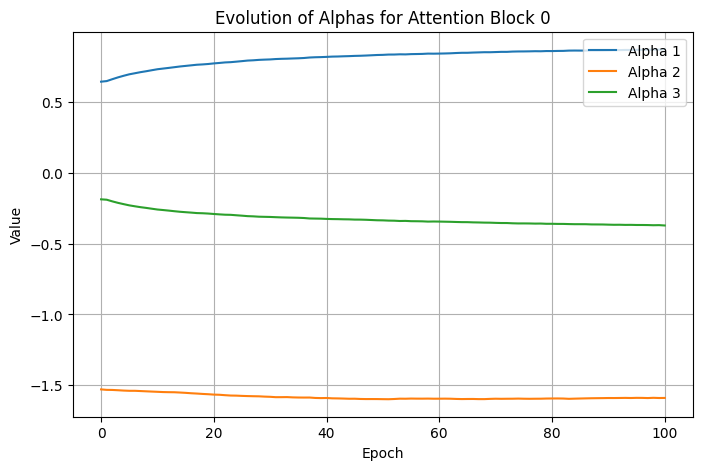

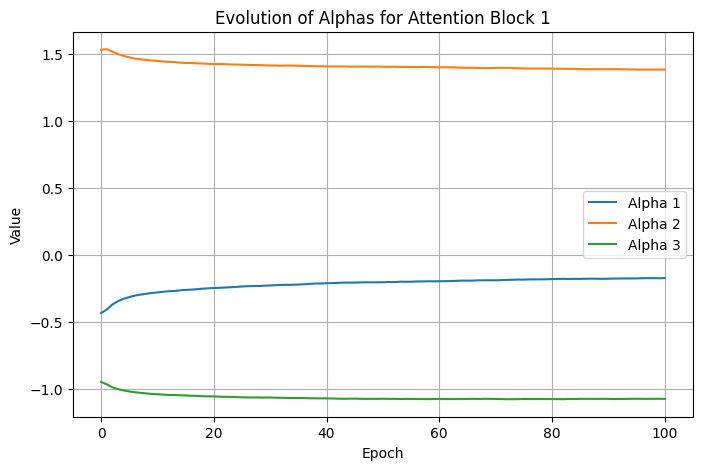

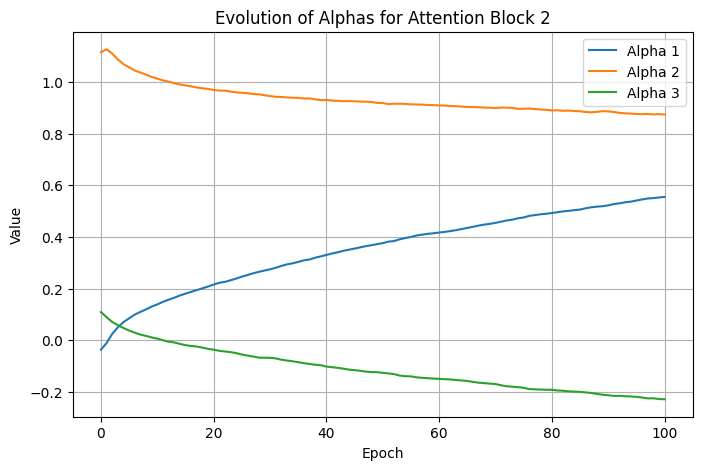

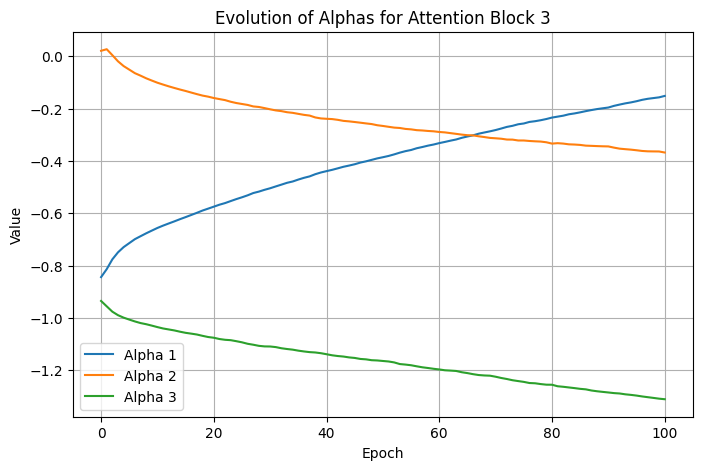

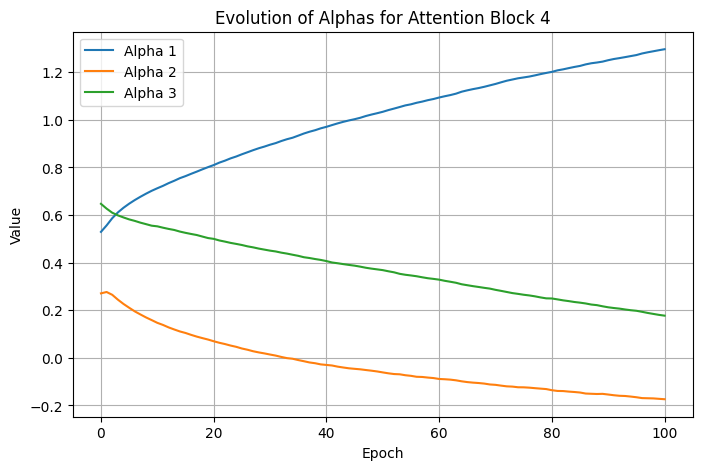

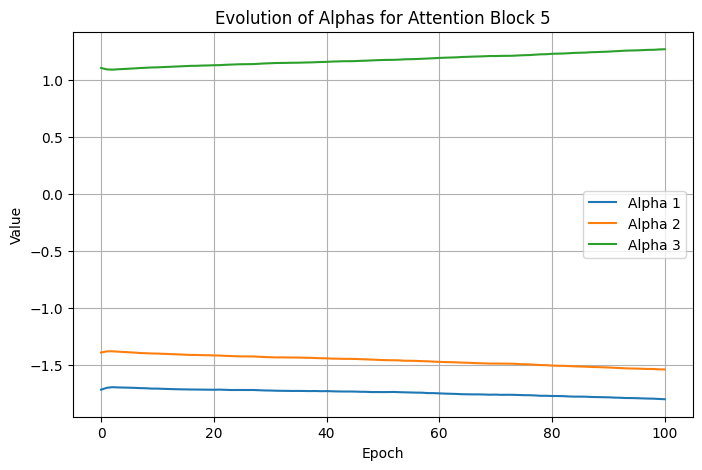

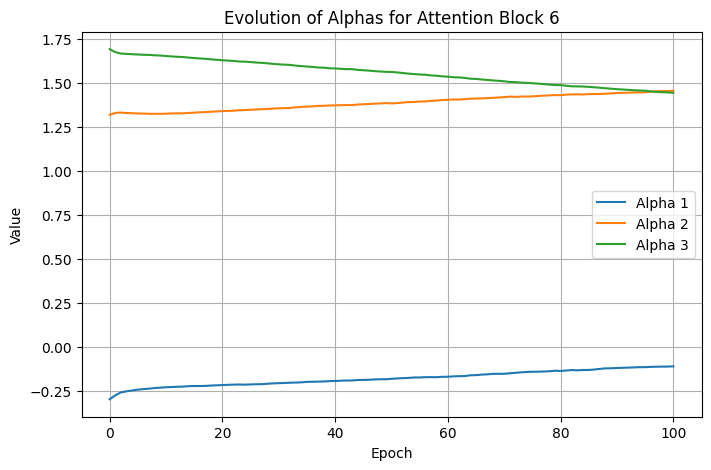

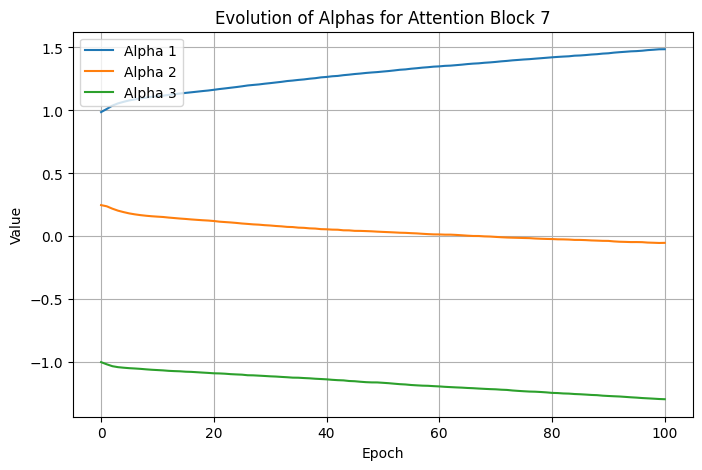

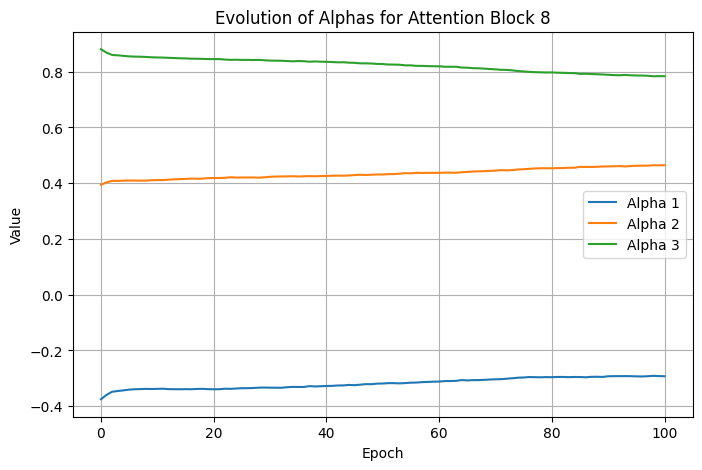

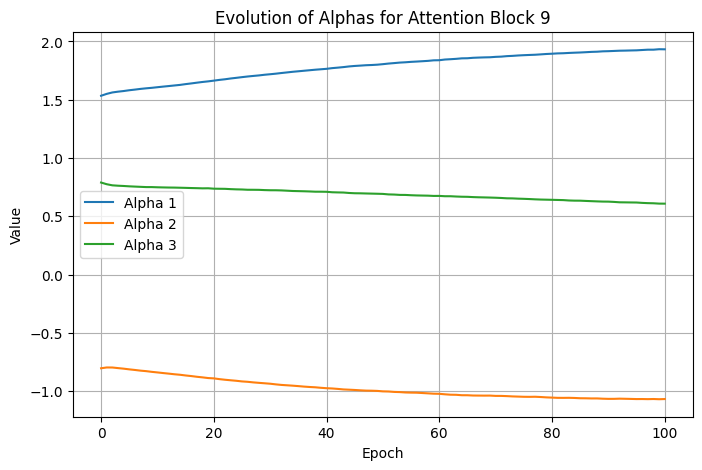

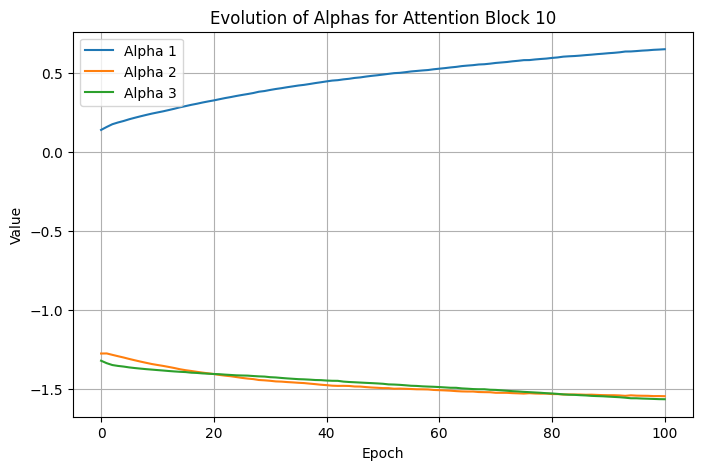

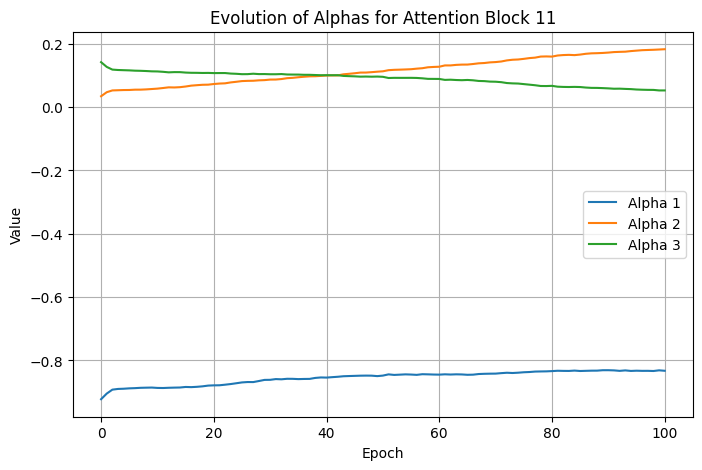

In [ ]:
# Iterate over each row index
print(all_alphas[0].shape)
for row_idx in range(all_alphas[0].shape[0]):
    plt.figure(figsize=(8, 5))

    # Extract the time series for each of the 3 entries
    time_series = np.array([matrix[row_idx] for matrix in all_alphas])

    # Plot each of the 3 columns over time
    for col_idx in range(3):
        plt.plot(time_series[:, col_idx], label=f'Alpha {col_idx + 1}')

    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'Evolution of Alphas for Attention Block {row_idx}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# ------------------------------
# Conclusion:
# ------------------------------
# In this notebook we demonstrated how to replace the standard attention mechanism with
# a learnable attention mask that is a weighted combination of several candidate masks.
# By optimizing the weights (with an L1 penalty to encourage sparsity) and minimizing
# the KL divergence between our custom model and a baseline GPT-2 model, we aim to preserve
# generation quality while potentially reducing the computational cost (by selecting only
# the most relevant tokens). This approach can be extended and refined for further research
# into efficient attention mechanisms.